In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from scipy.optimize import curve_fit
from sklearn import metrics
from loading_data import *
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
ncg_consumption, gaspool_consumption, the_consumption = read_consumption()
consumption_data = pd.concat([ncg_consumption.add(gaspool_consumption, fill_value=0), the_consumption])
consumption_data = pd.DataFrame(consumption_data, columns=["consumption"])

temperature = read_weather()

consumption_data_clean = consumption_data.dropna()
temperature_clean = temperature.dropna()

common_index = consumption_data_clean.index.intersection(temperature_clean.index)

consumption_data = consumption_data_clean.loc[common_index]
consumption_data = pd.DataFrame(consumption_data)
temperature = temperature_clean.loc[common_index]


In [5]:
# compter les na dans les series
print(consumption_data.isna().sum())
print(temperature.isna().sum())

consumption    0
dtype: int64
temperature_2m_max (°C)      0
temperature_2m_min (°C)      0
temperature_2m_mean (°C)     0
sunshine_duration (h)        0
wind_speed_10m_max (km/h)    0
dtype: int64


## Diagram temperature & natural gas consumption

In [31]:
consumption_data["consumption"].loc["2018/01/01":].corr(temperature["temperature_2m_mean (°C)"].loc["2018/01/01":])

np.float64(-0.9179922956114716)

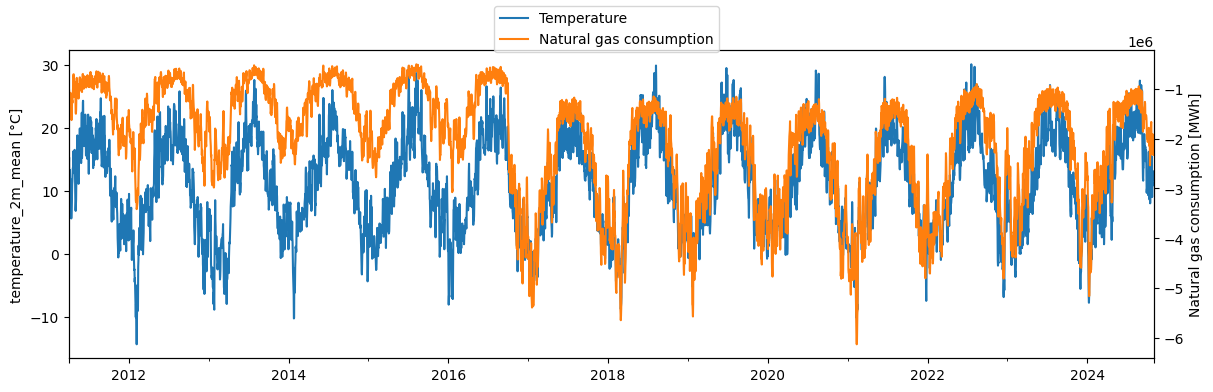

In [33]:
import os

fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temperature["temperature_2m_mean (°C)"].plot(ax=ax1, color="tab:blue")
(consumption_data["consumption"] * -1).plot(ax=ax2, color="tab:orange") # Invert the consumption axis

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C]")
ax2.set_ylabel("Natural gas consumption [MWh]")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/data_analysis_003_001.svg", format="svg", bbox_inches="tight")

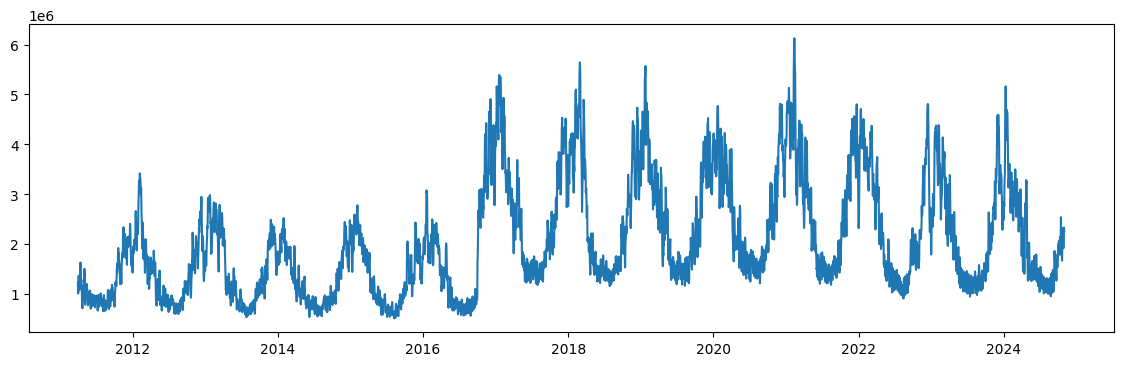

In [35]:
# gerer les dimension sur l'axe des x
fig, ax1 = plt.subplots(figsize=(14, 4))
plt.plot(consumption_data)

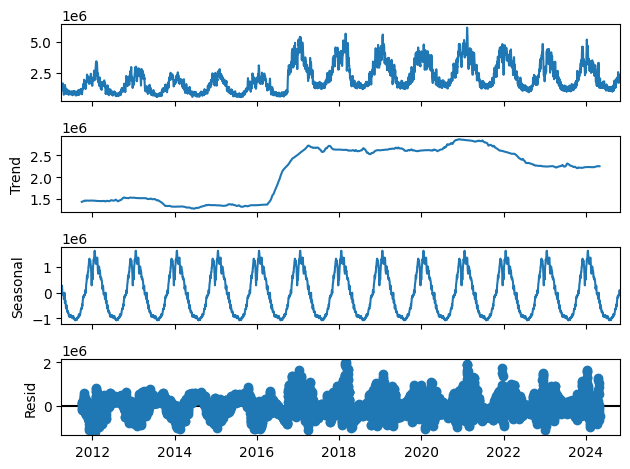

In [36]:

# Décomposition additive
result_add = seasonal_decompose(consumption_data, model='additive', period=365)  # Ajustez 'period' à la fréquence de vos données
result_add.plot()
plt.show()


## Regression analysis

In [6]:
def calculate_monthly_deviation(data, resample_freq='ME', agg_func='mean'):
    # Resample et agrégation mensuelle
    data_monthly = data.resample(resample_freq).agg(agg_func)
    
    # Moyenne par mois
    data_monthly_mean = data_monthly.groupby(data_monthly.index.month).mean()
    data_monthly_mean.index = pd.to_datetime(data_monthly_mean.index, format="%m").month_name()
    
    # Calcul des écarts
    monthly_deviation = pd.DataFrame()
    for month in data_monthly_mean.index:
        # Obtenir le numéro du mois (1 = janvier, ..., 12 = décembre)
        month_number = pd.to_datetime(month, format='%B').month
        # Filtrer les lignes du premier DataFrame correspondant au mois actuel
        monthly_values = data_monthly[data_monthly.index.month == month_number]
        # Récupérer la valeur moyenne pour le mois actuel dans le second DataFrame
        monthly_mean = data_monthly_mean.loc[month]
        # Calculer les écarts
        result = monthly_values - monthly_mean
        # Ajouter les écarts au DataFrame final
        monthly_deviation = pd.concat([monthly_deviation, result])
    
    return monthly_deviation.sort_index()


In [12]:
temperature_monthly_deviation = calculate_monthly_deviation(temperature, resample_freq='ME', agg_func='mean')
consumption_monthly_deviation = calculate_monthly_deviation(consumption_data, resample_freq='ME', agg_func='sum')

correlation = consumption_monthly_deviation.iloc[:, 0].corr(
    temperature_monthly_deviation["temperature_2m_mean (°C)"]
)
print(correlation)

-0.12228042637869665


In [13]:
temperature_monthly_deviation 

,temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),sunshine_duration (h),wind_speed_10m_max (km/h)
2011-04-30,2.837381,2.185238,2.520476,0.133464,-0.717857
2011-05-31,1.394470,-0.238249,0.653917,1.392407,-1.299309
2011-06-30,-0.142381,-0.207381,-0.216190,0.522773,-0.058333
2011-07-31,-3.341014,-1.150000,-2.257143,-3.363211,1.074885
2011-08-31,-2.085023,-0.847926,-1.432488,0.085173,0.243779
...,...,...,...,...,...
2024-06-30,-0.952381,-0.687381,-0.769524,0.085606,1.311667
2024-07-31,0.842857,0.095161,0.533180,0.089340,0.713594
2024-08-31,1.882719,0.626267,1.361060,0.527260,0.688940
2024-09-30,2.042619,1.470476,1.560238,0.047539,4.666905


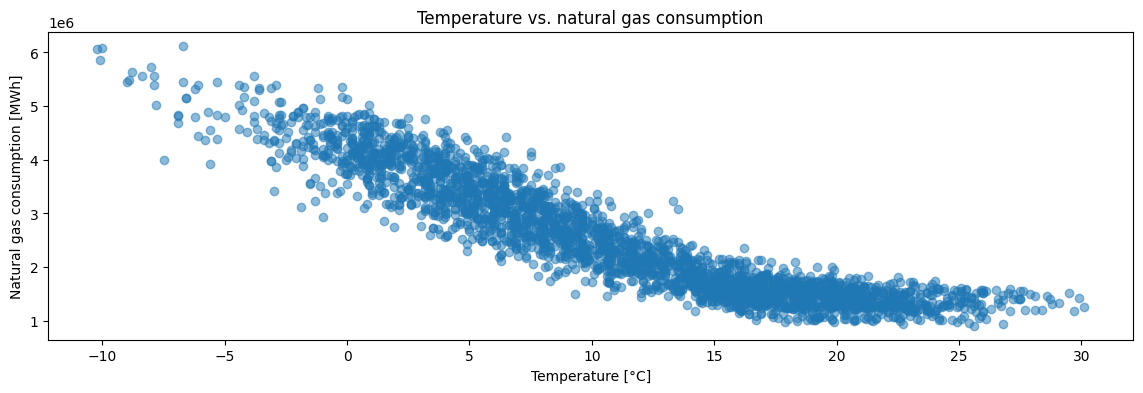

In [52]:
# Scatter plot of temperature and natural gas consumption
temperature_filtered = temperature["temperature_2m_mean (°C)"].loc["2017/01/01":]
consumption_filtered = consumption_data["consumption"].loc["2017/01/01":]
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temperature_filtered, consumption_filtered, alpha=0.5) 


# Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. natural gas consumption")

# Save plot
fig.savefig("diagrams/data_analysis_003_003.svg", format="svg", bbox_inches="tight")

Paramètres ajustés : a = -37410309.88116271, b = 213878412.18547726


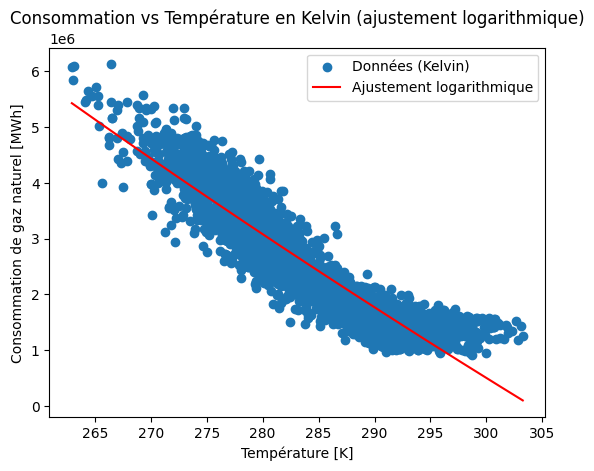

In [44]:
def func_log(x, a, b):
    return a * np.log(x) + b

temperature_kelvin = temperature["temperature_2m_mean (°C)"].loc["2017/01/01":] + 273.15
consumption_filtered = consumption_data["consumption"].loc["2017/01/01":]
# Ajuster la fonction aux données
params, covariance = curve_fit(func_log, temperature_kelvin, consumption_filtered)

# Récupérer les paramètres ajustés
a, b = params
print(f"Paramètres ajustés : a = {a}, b = {b}")

# Tracer les points et la courbe ajustée
x_vals = np.linspace(min(temperature_kelvin), max(temperature_kelvin), 500)
y_vals = func_log(x_vals, a, b)

plt.scatter(temperature_kelvin, consumption_filtered, label='Données (Kelvin)')
plt.plot(x_vals, y_vals, color='red', label='Ajustement logarithmique')
plt.xlabel('Température [K]')
plt.ylabel('Consommation de gaz naturel [MWh]')
plt.title('Consommation vs Température en Kelvin (ajustement logarithmique)')
plt.legend()
plt.show()

## Régression polynomiale 

### En daily 

Coefficients : [-203743.08245766    3273.36114983]
Intercept : 4194228.704009551
Erreur quadratique moyenne (MSE) : 136433060150.658
R² : 0.886


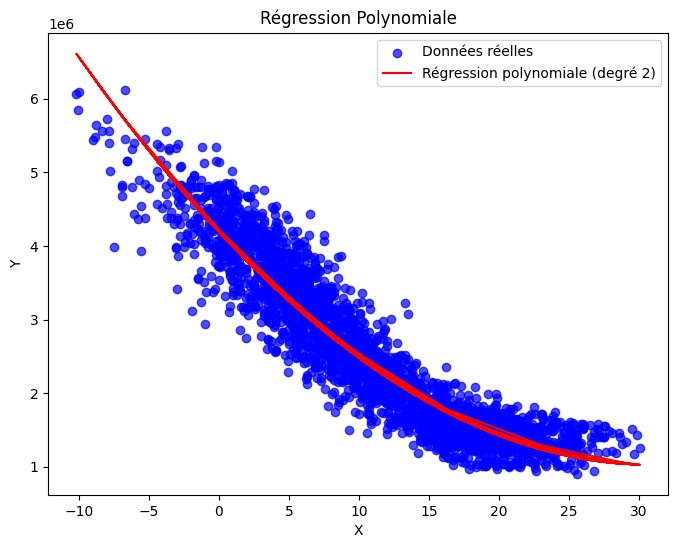

In [53]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = temperature_filtered
Y = consumption_filtered

# Transformation des données pour inclure des termes polynomiaux
degree = 2  # Degré du polynôme
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly_features.fit_transform(X.values.reshape(-1, 1))

# Modèle de régression linéaire sur les termes polynomiaux
model = LinearRegression()
model.fit(X_poly, Y)

# Prédictions
Y_pred = model.predict(X_poly)

# Coefficients du polynôme
coefficients = model.coef_
intercept = model.intercept_
print(f"Coefficients : {coefficients}")
print(f"Intercept : {intercept}")

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(Y, Y_pred)
print(f"Erreur quadratique moyenne (MSE) : {mse:.3f}")

# Calcul du coefficient de détermination
r2 = model.score(X_poly, Y)
print(f"R² : {r2:.3f}")

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, label="Données réelles", color="blue", alpha=0.7)
plt.plot(X, Y_pred, label=f"Régression polynomiale (degré {degree})", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Régression Polynomiale")
plt.legend()
plt.show()

### En monthly

In [64]:
temperature_monthly = temperature_filtered.resample('ME').agg('mean')
consumpation_monthly = consumption_filtered.resample('ME').agg('sum')

Coefficients : [-7051720.32550119   128402.82416141]
Intercept : 132987745.44347459
Erreur quadratique moyenne (MSE) : 49748187962511.344
R² : 0.946


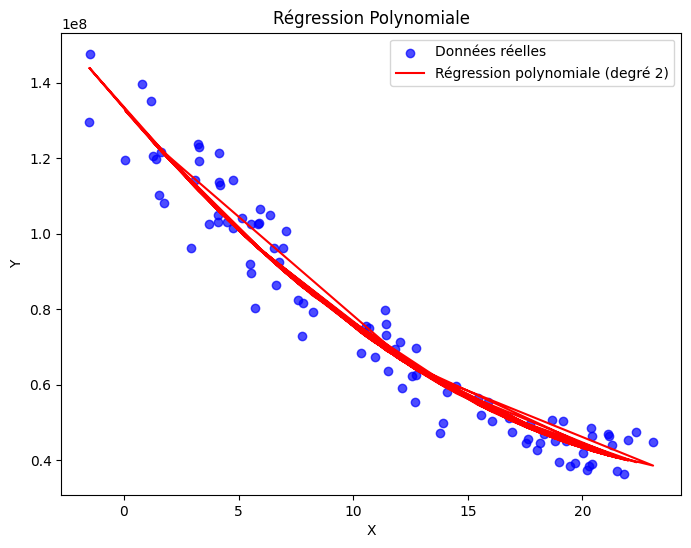

In [62]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = temperature_monthly
Y = consumpation_monthly

# Transformation des données pour inclure des termes polynomiaux
degree = 2  # Degré du polynôme
poly_features = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly_features.fit_transform(X.values.reshape(-1, 1))

# Modèle de régression linéaire sur les termes polynomiaux
model = LinearRegression()
model.fit(X_poly, Y)

# Prédictions
Y_pred = model.predict(X_poly)

# Coefficients du polynôme
coefficients = model.coef_
intercept = model.intercept_
print(f"Coefficients : {coefficients}")
print(f"Intercept : {intercept}")

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(Y, Y_pred)
print(f"Erreur quadratique moyenne (MSE) : {mse:.3f}")

# Calcul du coefficient de détermination
r2 = model.score(X_poly, Y)
print(f"R² : {r2:.3f}")

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, label="Données réelles", color="blue", alpha=0.7)
plt.plot(X, Y_pred, label=f"Régression polynomiale (degré {degree})", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Régression Polynomiale")
plt.legend()
plt.show()

0.5680183151915658


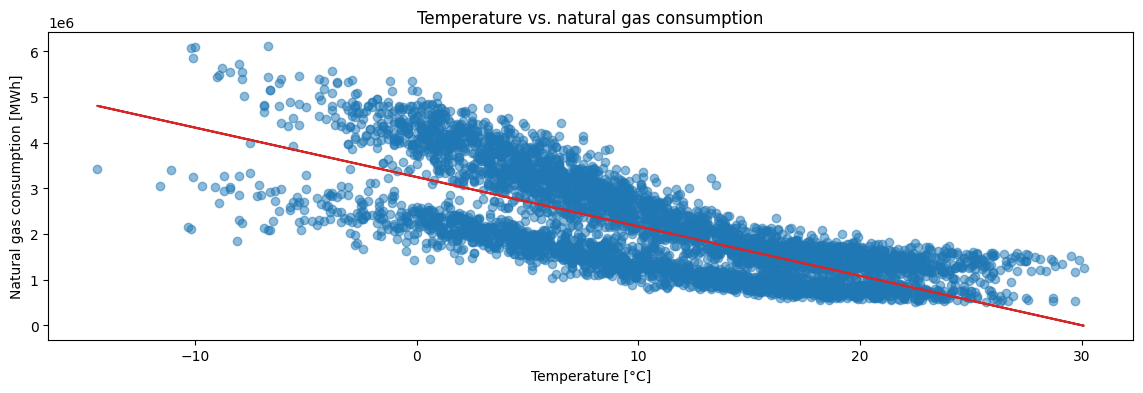

In [9]:
linear_regression = stats.linregress(temperature["temperature_2m_mean (°C)"], consumption_data)

# print r^2
print(linear_regression.rvalue**2)

# Plot linear regression
regression_y = linear_regression.slope * temperature["temperature_2m_mean (°C)"] + linear_regression.intercept

# Scatter plot of temperature and natural gas consumption
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(temperature["temperature_2m_mean (°C)"], consumption_data, alpha=0.5)

# Plot linear regression
ax.plot(temperature["temperature_2m_mean (°C)"], regression_y, color="tab:red")

# Labels and legend
ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Natural gas consumption [MWh]")
ax.set_title("Temperature vs. natural gas consumption")

# Save plot
fig.savefig("diagrams/data_analysis_003_004.svg", format="svg", bbox_inches="tight")
